# Load Data & Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_455_GDRIVE = './drive/Shareddrives/CSE455 Final Project'
FORMATTED_DATA_PATH_GDRIVE = './drive/Shareddrives/CSE455 Final Project/balanced_formatted_data_2'
FACE_DETECTION_PATH_GDRIVE = PATH_455_GDRIVE + '/face-detection-pytorch-master/'
TAR_DATA_PATH = PATH_455_GDRIVE + '/balanced_formatted_data.tar'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
import os
import shutil
import seaborn as sns
import pandas as pd
import time

from torch.utils.data import SubsetRandomSampler
from torch.optim import lr_scheduler
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage import exposure
from skimage.util import random_noise
from PIL import Image

os.chdir(FACE_DETECTION_PATH_GDRIVE)
from detectors import FaceBoxes
from utils import draw_bboxes, crop_thumbnail, draw_bbox

# load detector with device(cpu or cuda)
DET = FaceBoxes(device='cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.chdir('/content/')
print(device)

[FaceBoxes] loading with cuda
[FaceBoxes] finished loading (0.0445 sec)
cuda:0


In [ ]:
os.chdir('/content/')
!ls ./drive/Shareddrives/CSE455\ Final\ Project
!pwd

 AgnezMo			 formatted_data        Other
 balanced_formatted_data	 formatted_data_crpd   Other-4
 balanced_formatted_data.tar	 Human_Benchmark       Presentation.gslides
 Brad-Pitt			 Justin-Bieber	       Raven-Samone
'colab links.gdoc'		 Justin-Bieber-4       Sanchit
 data_crop.tar			 Mallory	       Sanchit-4
 data_new.tar			 Mallory-4	       test3
 Emma-Watson			 model-checkpoint
 face-detection-pytorch-master	 new_formatted_data
/content


# Data Augmentation
Given our datatset, make sure that each age category has at least NUM_PICTURES pictures using data augmentation. Make sure this portion is commented once it's run


In [ ]:
NUM_PICTURES = 300 # there are these many images for each of baby, tween, teen....

def cropped(image):
  bboxes = DET.detect_faces(image, conf_th=0.75)

  # crop thumbnail from original image.
  results = []
  for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(image, bbox, padding=1, size=256)
      results.append(thumb_img)

  if results:
    return results[0]
  
  return image


def anticlockwise_rotation(image):
  angle= random.randint(0, 90)
  return rotate(image, angle)

def lighten(image):
  return exposure.adjust_gamma(image, gamma=0.5,gain=1)

def darken(image):
  return exposure.adjust_gamma(image, gamma=1.5,gain=1)

def clockwise_rotation(image):
  angle= random.randint(0, 90)
  return rotate(image, -angle)

def h_flip(image):
  return  np.fliplr(image)

def add_noise(image):
  return random_noise(image)

def blur_image(image):
  return cv2.GaussianBlur(image, (9,9),0)
  
transformations = {
                    'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'horizontal flip': h_flip, 
                    'adding noise': add_noise,
                    'blurring image':blur_image,
                    'lighten':lighten,
                    'darken':darken,
                  } 

def augment_images():
  # people to whom we need to apply transformations
  rand_list = [0,1,2,3,4,5,6]
  #people = ["Sanchit", "Mallory", "Raven-Samone", "Other", "Justin-Bieber", "AgnezMo"]
  # the list below has 4 categories per person
  people = ["Sanchit-4", "Mallory-4", "Raven-Samone", "Other-4", "Justin-Bieber-4", "AgnezMo"]
  cropped_path = './drive/Shareddrives/CSE455 Final Project'
  destination_path = FORMATTED_DATA_PATH_GDRIVE

  for person in people:
    print("Augmented {} photos".format(person))
    person_path = cropped_path + '/' + person + '/cropped'
    for age in os.listdir(person_path):  # read image name from folder and append its path into "images" array
      print(age)
      images = []
      age_path = person_path + '/' + age
      for im in os.listdir(age_path):
        image_path = age_path + '/' + im
        images.append(image_path)

      # create training and test split for images of this age category
      random.shuffle(images)
      train_images = images[:int(len(images) * 0.8)]
      print("train count: " + str(len(train_images)))
      test_images = images[int(len(images) * 0.8):]
      print("test count: " + str(len(test_images)))

      # generate 80% of NUM_PICTURES total images for this person's age class TRAIN
      destination_path_person = destination_path + '/train/' + person
      os.makedirs(destination_path_person, exist_ok=True)
      i=1
      while i <= (NUM_PICTURES * 0.8):    
        image = random.choice(train_images)
        original_image = cv2.imread(image)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        # original_image = io.imread(image)

        isCropped = random.randrange(10)
        if isCropped in rand_list: # 40% chance the image is being cropped
          original_image = cropped(original_image)

        transformed_image = None
        n = 0       #variable to iterate till number of transformation to apply
        transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
        
        while n <= transformation_count:
          key = random.choice(list(transformations)) #randomly choosing method to call
          transformed_image = transformations[key](original_image)
          n = n + 1
            
        new_image_path = destination_path_person + '/' + age + str(i) + '.jpg'
        transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
        transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
        cropped_image = cropped(transformed_image)
        cv2.imwrite(new_image_path, cropped_image) # save transformed image to path
        i =i+1
      
      # generate 20% of NUM_PICTURES total images for this person's age class TEST
      destination_path_person = destination_path + '/test/' + person
      os.makedirs(destination_path_person, exist_ok=True)
      i=1
      while i <= (NUM_PICTURES * 0.2):    
        image = random.choice(test_images)
        original_image = cv2.imread(image)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        # original_image = io.imread(image)

        isCropped = random.randrange(10)
        if isCropped in rand_list: # 40% chance the image is being cropped
          original_image = cropped(original_image)

        transformed_image = None
        n = 0       #variable to iterate till number of transformation to apply
        transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
        
        while n <= transformation_count:
          key = random.choice(list(transformations)) #randomly choosing method to call
          transformed_image = transformations[key](original_image)
          n = n + 1
            
        new_image_path = destination_path_person + '/' + age + str(i) + '.jpg'
        transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
        transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
        cropped_image = cropped(transformed_image)
        cv2.imwrite(new_image_path, cropped_image) # save transformed image to path
        i =i+1

  
  print("Augmented Done")

augment_images() # MAKE SURE THIS IS COMMENTED UNLESS YOU WANT TO GENERATE AUGMENTS

Augmented Sanchit-4 photos
child
train count: 8
test count: 3
tween
train count: 24
test count: 7
teen:adult
train count: 40
test count: 10
baby:toddler
train count: 6
test count: 2
Augmented Mallory-4 photos
child
train count: 17
test count: 5
tween
train count: 4
test count: 1
baby:toddler
train count: 26
test count: 7
teen:adult
train count: 43
test count: 11
Augmented Raven-Samone photos
adult
train count: 16
test count: 5
child
train count: 16
test count: 5
teen
train count: 14
test count: 4
tween
train count: 8
test count: 2
Augmented Other-4 photos
child
train count: 34
test count: 9
teen:adult
train count: 79
test count: 20
tween
train count: 18
test count: 5
toddler:baby
train count: 39
test count: 10
Augmented Justin-Bieber-4 photos
tween
train count: 8
test count: 3
child
train count: 10
test count: 3
baby:toddler
train count: 12
test count: 3
teen:adult
train count: 35
test count: 9
Augmented AgnezMo photos
adult
train count: 10
test count: 3
teen
train count: 6
test count:

# Copy Data to Local Env

In [ ]:
# shutil.rmtree('formatted_data') # delete local formatted data

In [ ]:
def copy_data():
  if not os.path.exists('balanced_formatted_data'):
    if not os.path.exists(TAR_DATA_PATH):
      print("Can't find the tar file.. Please upload the tar file to google drive")
      return
    print("Copying to Colab's local drive..")
    shutil.copy(TAR_DATA_PATH, './data.tar')
    print("Uncompressing..")
    !tar --exclude='._*' -xf data.tar # mac generates ._ files
    
  print("Data ready!!")

copy_data()

Copying to Colab's local drive..
Uncompressing..
Data ready!!


# Face Detection

info from: https://github.com/cs-giung/face-detection-pytorch



detect 5 faces in 0.3510 seconds.
crop 5 faces in 0.0388 seconds.


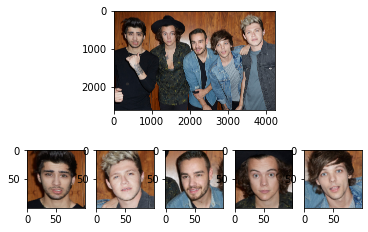

In [ ]:
# detects and crops the faces in the given picture and returns those cropped pictures in an array
# if no faces are detected returns an empty array
# expects an image that is already converted to RGB
def crop_input(image):
  # DET returns bboxes.
  bboxes = DET.detect_faces(image, conf_th=0.9)

  # crop thumbnail from original image.
  results = []
  for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(image, bbox, padding=.7, size=256)
      results.append(thumb_img)

  # if no face is detected, lower confidence threshold
  if not results:
    bboxes = DET.detect_faces(image, conf_th=0.65)

    for i, bbox in enumerate(bboxes):
        thumb_img, _ = crop_thumbnail(image, bbox, padding=.7, size=100)
        results.append(thumb_img)

  # if there is still no face detected return empty directory
  return results

# below is an example of what crop_input does but with amount of time given

# load image in RGB
IMG_PATH = FACE_DETECTION_PATH_GDRIVE + '/one-direction.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# DSFD returns bboxes.
t = time.time()
bboxes = DET.detect_faces(img, conf_th=0.9)
print('detect %d faces in %.4f seconds.' % (len(bboxes), time.time() - t))

# crop thumbnail from original image.
results = []
t = time.time()
for i, bbox in enumerate(bboxes):
    thumb_img, _ = crop_thumbnail(img, bbox, padding=.7, size=100)
    results.append(thumb_img)
print('crop %d faces in %.4f seconds.' % (len(results), time.time() - t))

# plot results
grid = plt.GridSpec(2, len(results))
plt.subplot(grid[0, 0:]).imshow(img)
for i in range(len(results)):
    plt.subplot(grid[1, i]).imshow(results[i])
plt.show()



# Data Loader -- `get_data()`

Get Data from `formatted_data` folder.

The data are split into three categories: **training set**, **validation set**, and **test set**.

In [ ]:
# if we don't need validation set, set val = 0.0
def get_data(model_name, train_percent=0.9, val_percent=0.1):
  normalize = transforms.Normalize([0.485, 0.456, 0.406], 
                                   [0.229, 0.224, 0.225])
  
  # Load the image data, resize, and transform to tensor

  # different model need different image requirements
  if model_name == 'inception':
    transform = transforms.Compose(
        [transforms.Resize(size=325), 
         transforms.CenterCrop(299),
         transforms.ToTensor(),
         normalize])
  elif model_name == 'darknet':
    transform = transforms.Compose(
        [transforms.Resize(size=(256, 256)), 
        transforms.ToTensor(),
        normalize])
  elif model_name == 'resnet':
     transform = transforms.Compose(
         [transforms.Resize(256), 
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize])
    
  # load the image from formatted data folder
  train_dataset = torchvision.datasets.ImageFolder(
      root='./balanced_formatted_data/train/', 
      transform=transform)
  
  test_dataset = torchvision.datasets.ImageFolder(
      root='./balanced_formatted_data/test/', 
      transform=transform)
  
  # get the information for each data size
  train_dataset_size = len(train_dataset)
  train_size = int(np.floor(train_dataset_size * train_percent))
  val_size = int(np.floor(train_dataset_size * val_percent))
  test_size = len(test_dataset)

  # shuffling the training dataset index to get random training set and val set
  indexes = list(range(train_dataset_size))
  np.random.shuffle(indexes)
  index_train = indexes[:train_size]
  index_val = indexes[train_size:]

  # add up to 100%
  assert (len(index_train) + len(index_val)) == train_dataset_size

  # creating data loader for each set
  trainLoader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=32, 
                                            shuffle=False,
                                            num_workers=2,
                                            sampler=SubsetRandomSampler(
                                                index_train)
                                            )
  
  valLoader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=32, 
                                          shuffle=False,
                                          num_workers=2,
                                          sampler=SubsetRandomSampler(
                                              index_val)
                                          )
  
  testLoader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=32, 
                                           shuffle=False,
                                           num_workers=2,
                                           )
  
  # creating classes and idx2class
  classes = [None for i in range(6)]
  idx2class = {}

  for k, v in train_dataset.class_to_idx.items():
    idx2class[v] = k
    classes[v] = k

  print("Total image in training dataset: {}".format(train_dataset_size))
  print("Number of image in training set: {}".format(train_size))
  print("Number of image in validation set: {}".format(val_size))
  print("Number of image in test set: {}".format(test_size))

  return {'train': trainLoader, 
          'val': valLoader, 
          'test': testLoader, 
          'classes': classes,
          'idx2class': idx2class,
          'train_size': train_size,
          'val_size': val_size,
          'test_size': test_size
          }

# Data Viz

In [ ]:
def imshow(img):
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

def viz_data(data):
  dataiter = iter(data['train'])
  images, labels = dataiter.next()
  print(images.size())

  # show images
  imshow(torchvision.utils.make_grid(images[:8]))
  # print labels
  print("Labels:" + ' '.join(
      '%2s' % data['classes'][labels[j]] for j in range(8)))

  flat = torch.flatten(images, 1)
  print(images.size())
  print(flat.size())

# Convolutional Neural Network



## Training and Eval
Inception model's loss https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

In [ ]:
import copy
"""
  Training function
  
  return the model that achieves the highest validation accuracy
"""
def train(model, dataloader, criterion, optimizer, scheduler = None, epochs=1, 
          start_epoch=0, verbose=1, print_every=10, state=None,
          checkpoint_path=None, inception=False):
  
  model.to(device) # move to GPU if exists
  # model.train()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  losses = []
  
  # load training state, if any
  if state:
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    start_epoch = state['epoch']
    losses = state['losses']

  # Get the current lr for pretrained model
  for epoch in range(start_epoch):
    if scheduler:
      scheduler.step()
  
  # training
  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    for phase in ['train', 'val']:
      print("{} phase for epoch {}".format(phase, epoch))
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # iterate data in one batch
      for i, batch in enumerate(dataloader[phase], 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          # inception has two outputs, need to combine both output
          if inception and phase == 'train':
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + (0.4 * loss2)
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels) 

        _, preds = torch.max(outputs, 1)

        if phase == 'train':
          loss.backward()
          optimizer.step()

          losses.append(loss.item())
          sum_loss += loss.item()

          if (i % print_every) == (print_every - 1):
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, 
                                              sum_loss / print_every))
            sum_loss = 0.0 # reset the sum since we average / print_every

        if checkpoint_path:
          state = {'epoch': epoch + 1, 'model': model.state_dict(), 
                  'optimizer': optimizer.state_dict(), 'losses': losses}
          torch.save(state, checkpoint_path + 'checkpoint-%d.pkl' & (epoch+1))

     
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        size = dataloader['train_size']
      else:
        size = dataloader['val_size']
      
      epoch_loss = running_loss / size
      epoch_acc = running_corrects.double() / size
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  
    print()
    scheduler.step()
  
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model, losses

"""
  Calculating the models's accuracy
"""
def accuracy(model, dataloader):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader:
      images, labels = batch[0].to(device), batch[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  return correct / total

"""
  Smoothing the image for visualization
"""
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Neural Net Model

### Darknet256 -- Train from scratch

input size 256 x 256   
Testing accuracy: 0.982375

#### Data loading for darknet

Total image in training dataset: 5760
Number of image in training set: 5184
Number of image in validation set: 576
Number of image in test set: 1440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 256, 256])


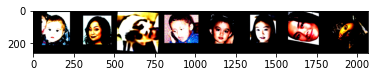

Labels:Justin-Bieber Raven-Samone Justin-Bieber Sanchit AgnezMo Other AgnezMo Raven-Samone
torch.Size([32, 3, 256, 256])
torch.Size([32, 196608])


In [ ]:
# get the data loader for darknet
darknet_data = get_data('darknet')
viz_data(darknet_data)

#### The model

In [ ]:
class Darknet256(nn.Module):
    def __init__(self):
        super(Darknet256, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512, 6)
        # self.fc2 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.5) # drop out 30% chance

    def forward(self, x):
        # Input 256x256x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 
                         kernel_size=2, stride=2) # 128x128x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 
                         kernel_size=2, stride=2) # 64x64x32
        # x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 
                         kernel_size=2, stride=2) # 32x32x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 
                         kernel_size=2, stride=2) # 16x16x128
        x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), 
                         kernel_size=2, stride=2) # 8x8x256
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), 
                         kernel_size=2, stride=2) # 4 x 4 x 512       

        # Global average pooling across each channel
        x = F.adaptive_avg_pool2d(x, 1) # 1x1x512
        x = torch.flatten(x, 1)         # vector 512
        
        x = self.fc1(x)
        # x = self.fc2(x)
        return x

#### Train the model

Set `TRAIN = True` to train the model

Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 0
[0,    10] loss: 3.245
[0,    20] loss: 1.884
[0,    30] loss: 1.824
[0,    40] loss: 1.672
[0,    50] loss: 1.743
[0,    60] loss: 1.675
[0,    70] loss: 1.653
[0,    80] loss: 1.622
[0,    90] loss: 1.623
[0,   100] loss: 1.570
[0,   110] loss: 1.520
[0,   120] loss: 1.546
[0,   130] loss: 1.545
[0,   140] loss: 1.452
[0,   150] loss: 1.472
[0,   160] loss: 1.468
train Loss: 1.7189 Acc: 0.3478
val phase for epoch 0
val Loss: 1.7349 Acc: 0.2726

Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 1
[1,    10] loss: 1.477
[1,    20] loss: 1.521
[1,    30] loss: 1.594
[1,    40] loss: 1.437
[1,    50] loss: 1.542
[1,    60] loss: 1.477
[1,    70] loss: 1.463
[1,    80] loss: 1.451
[1,    90] loss: 1.393
[1,   100] loss: 1.422
[1,   110] loss: 1.394
[1,   120] loss: 1.365
[1,   130] loss: 1.478
[1,   140] loss: 1.384
[1,   150] loss: 1.411
[1,   160] loss: 1.348
train Loss: 1.4448 Acc: 0.4304
va

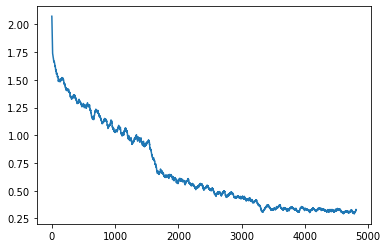

In [ ]:
TRAIN = False

if TRAIN:
  darknet256 = Darknet256()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(darknet256.parameters(), lr=.01, 
                          weight_decay=0.0005)

  # learning rate scheduler for training
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, 
                                        verbose=True)
  # train the model
  darknet256, losses = train(darknet256, darknet_data, criterion, optimizer, 
                scheduler=exp_lr_scheduler, epochs=30) 

  print("Testing accuracy: %f" % accuracy(darknet256, darknet_data['test']))
  plt.plot(smooth(losses,50))

#### Save and Load the model

```python
# Save:
torch.save(model.state_dict(), PATH)

# Load:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
````


##### Save
Uncommented if you want to save the model


In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/darknet256_new.pt'
# torch.save(darknet256.state_dict(), model_save_path)

##### Load

In [ ]:
# load the model
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/darknet256_new.pt'

darknet256 = Darknet256()
darknet256.load_state_dict(torch.load(model_save_path))
darknet256.eval()
darknet256.to(device)

Darknet256(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (

### Inception v3 -- Transfer Learning
input size 299 x 299  

Testing accuracy: 0.776389 -- balanced formatted data

#### Data loading

Total image in training dataset: 5760
Number of image in training set: 5184
Number of image in validation set: 576
Number of image in test set: 1440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 299, 299])


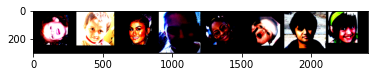

Labels:Mallory Sanchit AgnezMo Mallory Raven-Samone Justin-Bieber Sanchit AgnezMo
torch.Size([32, 3, 299, 299])
torch.Size([32, 268203])


In [ ]:
# load the data loader for inception model
inception_data = get_data('inception')
viz_data(inception_data)

#### Load and train the model
set `TRAIN = True` to train the model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 0
[0,    10] loss: 2.403
[0,    20] loss: 1.718
[0,    30] loss: 1.080
[0,    40] loss: 0.861
[0,    50] loss: 0.928
[0,    60] loss: 0.964
[0,    70] loss: 0.755
[0,    80] loss: 0.789
[0,    90] loss: 0.589
[0,   100] loss: 0.603
[0,   110] loss: 0.520
[0,   120] loss: 0.340
[0,   130] loss: 0.340
[0,   140] loss: 0.351
[0,   150] loss: 0.322
[0,   160] loss: 0.356
train Loss: 0.8022 Acc: 0.7820
val phase for epoch 0
val Loss: 1.6907 Acc: 0.5816

Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 1
[1,    10] loss: 0.167
[1,    20] loss: 0.204
[1,    30] loss: 0.186
[1,    40] loss: 0.171
[1,    50] loss: 0.200
[1,    60] loss: 0.315
[1,    70] loss: 0.177
[1,    80] loss: 0.137
[1,    90] loss: 0.210
[1,   100] loss: 0.087
[1,   110] loss: 0.102
[1,   120] loss: 0.106
[1,   130] loss: 0.138
[1,   140] loss: 0.130
[1,   150] loss: 0.157
[1,   160] loss: 0.136
train Loss: 0.1627 Acc: 0.9612
va

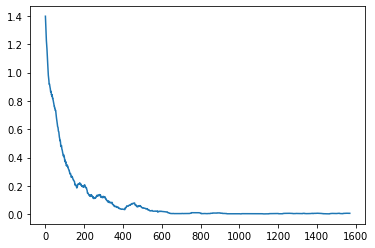

In [ ]:
TRAIN = False

if TRAIN:
  inception_v3 = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', 
                                pretrained=True)
  
  # freezing all layers and only train the last layer
  # for param in inception_v3.parameters():
  #   param.requires_grad = False

  # reinitialized the aux net to match our dataset
  num_ftrs = inception_v3.AuxLogits.fc.in_features
  inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes
  # reinitialized the primary net
  num_ftrs = inception_v3.fc.in_features
  inception_v3.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(inception_v3.parameters(), lr=.01, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(
      optimizer, step_size=3, gamma=0.1, verbose=True)

  inception_v3, losses = train(
      inception_v3, inception_data, criterion, optimizer, 
      scheduler=exp_lr_scheduler, epochs=10, inception = True) 

  print("Testing accuracy: %f" % accuracy(inception_v3, inception_data['test']))
  plt.plot(smooth(losses,50))

#### Save and Load the model

##### Save the model

In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/inception_new_small_batch.pt'
# torch.save(inception_v3.state_dict(), model_save_path) # uncommented this to save the model

##### Load the model

In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/inception_new_small_batch.pt'

inception_v3 = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', 
                              pretrained=True)

# change the last layer
# aux net
num_ftrs = inception_v3.AuxLogits.fc.in_features
inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes
# primary net
num_ftrs = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes

inception_v3.load_state_dict(torch.load(model_save_path))
inception_v3.eval()
inception_v3.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### ResNet152 -- Transfer Learning

input size 224x224    
Testing accuracy: 0.998130     
w/ balanced formatted
Testing accuracy: 0.759722


#### Data Loading

Total image in training dataset: 5760
Number of image in training set: 5184
Number of image in validation set: 576
Number of image in test set: 1440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


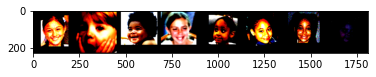

Labels:AgnezMo Justin-Bieber Other Mallory Raven-Samone Raven-Samone Raven-Samone Mallory
torch.Size([32, 3, 224, 224])
torch.Size([32, 150528])


In [ ]:
resnet_data = get_data('resnet')
viz_data(resnet_data)

#### Train the model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 0
[0,    10] loss: 1.613
[0,    20] loss: 0.965
[0,    30] loss: 0.641
[0,    40] loss: 0.541
[0,    50] loss: 0.714
[0,    60] loss: 0.734
[0,    70] loss: 0.760
[0,    80] loss: 0.599
[0,    90] loss: 0.401
[0,   100] loss: 0.532
[0,   110] loss: 0.371
[0,   120] loss: 0.233
[0,   130] loss: 0.299
[0,   140] loss: 0.260
[0,   150] loss: 0.393
[0,   160] loss: 0.337
train Loss: 0.5829 Acc: 0.8003
val phase for epoch 0
val Loss: 0.5194 Acc: 0.8160

Adjusting learning rate of group 0 to 1.0000e-02.
train phase for epoch 1
[1,    10] loss: 0.243
[1,    20] loss: 0.214
[1,    30] loss: 0.287
[1,    40] loss: 0.184
[1,    50] loss: 0.177
[1,    60] loss: 0.177
[1,    70] loss: 0.174
[1,    80] loss: 0.218
[1,    90] loss: 0.234
[1,   100] loss: 0.170
[1,   110] loss: 0.060
[1,   120] loss: 0.042
[1,   130] loss: 0.072
[1,   140] loss: 0.116
[1,   150] loss: 0.078
[1,   160] loss: 0.044
train Loss: 0.1539 Acc: 0.9493
va

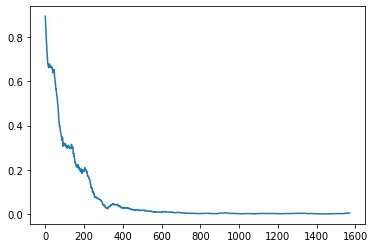

In [ ]:
TRAIN = False

if TRAIN:
  resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', 
                             pretrained=True)

  # reinitialized the last layer to fit our dataset
  num_ftrs = resnet152.fc.in_features
  resnet152.fc = nn.Linear(num_ftrs, 6) # we have 6 categories
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(resnet152.parameters(), lr=.01, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, 
                                        verbose=True)

  resnet152, losses = train(resnet152, resnet_data, criterion, optimizer, 
                            scheduler=exp_lr_scheduler, epochs=10)

  print("Testing accuracy: %f" % accuracy(resnet152, resnet_data['test']))
  plt.plot(smooth(losses,50))

#### Save and Load

##### Save the model

In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/resnet152_new.pt'
# torch.save(resnet152.state_dict(), model_save_path) # uncommented this to save the model

##### Load the model

In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/resnet152_new.pt'

resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', 
                           pretrained=True)

# change the final layer
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 6) 

resnet152.load_state_dict(torch.load(model_save_path))
resnet152.eval()
resnet152.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### VGG

#### Data Loading

Total image in training dataset: 5760
Number of image in training set: 5184
Number of image in validation set: 576
Number of image in test set: 1440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


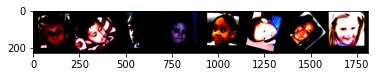

Labels:Mallory Sanchit Justin-Bieber Mallory Raven-Samone Sanchit Raven-Samone Mallory
torch.Size([32, 3, 224, 224])
torch.Size([32, 150528])


In [ ]:
vgg_data = get_data('resnet')
viz_data(vgg_data)

#### The model

In [ ]:
import torch
import torch.nn as nn

class Vgg_face_dag(nn.Module):
    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

#### Model Training

Adjusting learning rate of group 0 to 1.0000e-03.
train phase for epoch 0
[0,    10] loss: 1.780
[0,    20] loss: 1.655
[0,    30] loss: 1.461
[0,    40] loss: 1.254
[0,    50] loss: 1.262
[0,    60] loss: 1.147
[0,    70] loss: 1.141
[0,    80] loss: 1.101
[0,    90] loss: 1.008
[0,   100] loss: 1.035
[0,   110] loss: 1.105
[0,   120] loss: 0.943
[0,   130] loss: 1.005
[0,   140] loss: 1.022
[0,   150] loss: 0.955
[0,   160] loss: 0.899
train Loss: 1.1691 Acc: 0.5440
val phase for epoch 0
val Loss: 0.8739 Acc: 0.6927

Adjusting learning rate of group 0 to 1.0000e-03.
train phase for epoch 1
[1,    10] loss: 0.814
[1,    20] loss: 0.769
[1,    30] loss: 0.788
[1,    40] loss: 0.787
[1,    50] loss: 0.812
[1,    60] loss: 0.817
[1,    70] loss: 0.792
[1,    80] loss: 0.742
[1,    90] loss: 0.682
[1,   100] loss: 0.682
[1,   110] loss: 0.641
[1,   120] loss: 0.608
[1,   130] loss: 0.775
[1,   140] loss: 0.587
[1,   150] loss: 0.617
[1,   160] loss: 0.608
train Loss: 0.7190 Acc: 0.7371
va

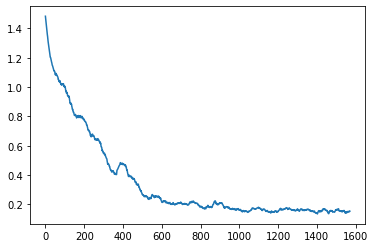

In [ ]:
# load the pretrained weight
vgg = vgg_face_dag(PATH_455_GDRIVE + '/model-checkpoint/vgg_face_dag.pth')
# change the last layer to fit our dataset
num_ftrs = vgg.fc8.in_features
vgg.fc8 = nn.Linear(num_ftrs, 6)
vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, 
                                       verbose=True)

vgg, losses = train(vgg, vgg_data, criterion, optimizer, 
                            scheduler=exp_lr_scheduler, epochs=10)

print("Testing accuracy: %f" % accuracy(vgg, vgg_data['test']))
plt.plot(smooth(losses,50))

#### Save and Load the model

In [ ]:
# save the model
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/vgg_new.pt'
# torch.save(vgg.state_dict(), model_save_path) # uncommented this to load the model's weigth

In [ ]:
# load the model
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/vgg_new.pt'

vgg = vgg_face_dag()

# change the final layer
num_ftrs = vgg.fc8.in_features
vgg.fc8 = nn.Linear(num_ftrs, 6)

vgg.load_state_dict(torch.load(model_save_path))
vgg.eval()
vgg.to(device)

Vgg_face_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3)

# Test The Models

## Functions

In [ ]:
import urllib.request

def cropped_im(image_path, model_name, verbose=True, local=True):
  if local:
    img = cv2.imread(image_path)
  else:
    with urllib.request.urlopen(image_path) as url:
      s = url.read()
      arr = np.asarray(bytearray(s), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'  

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  normalize = transforms.Normalize([0.485, 0.456, 0.406], 
                                   [0.229, 0.224, 0.225])
  
  # transform_norm is used for training, the transform for displaying the image
  if model_name == 'inception':
    transform_norm = transforms.Compose(
        [transforms.Resize(size=325), 
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        normalize])
    transform = transforms.Compose(
        [transforms.Resize(size=325), 
        transforms.CenterCrop(299),
        transforms.ToTensor()])
  elif model_name == 'darknet':
    transform_norm = transforms.Compose(
        [transforms.Resize(size=(256, 256)), 
        transforms.ToTensor(),
        normalize])
    transform = transforms.Compose(
        [transforms.Resize(size=(256, 256)), 
        transforms.ToTensor()])
  elif model_name == 'resnet':
     transform_norm = transforms.Compose(
         [transforms.Resize(256), 
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize])
     transform = transforms.Compose(
         [transforms.Resize(256), 
          transforms.CenterCrop(224),
          transforms.ToTensor()])
    
  # DSFD returns bboxes.
  bboxes = DET.detect_faces(img, conf_th=0.9)

  # crop thumbnail from original image.
  results = []
  for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(img, bbox, padding=1, size=100)
      thumb_img = Image.fromarray(thumb_img) # convert to PIL image
      image_transform = transform_norm(thumb_img) # apply transformation
      results.append((image_transform, transform(thumb_img)))

  # if with higher confident can't detect a person, retry with lower conf
  if not results:
    bboxes = DET.detect_faces(img, conf_th=0.65)

    for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(img, bbox, padding=1, size=100)
      thumb_img = Image.fromarray(thumb_img) # convert to PIL image
      image_transform = transform_norm(thumb_img) # apply transformation
      results.append((image_transform, transform(thumb_img)))

  # plot results
  # plot original image
  if verbose:
    grid = plt.GridSpec(2, len(results))
    plt.subplot(grid[0, 0:]).imshow(img)
    plt.show()
    # print cropped image
    # imshow(torchvision.utils.make_grid(results))

  return results if results else img


def predict_pics(model, image_list, idx2class):
  results = []

  for i in range(len(image_list)):
    image = image_list[i][0].to(device)
    outputs = model(image[None, ...]) # predict
    _, predicted = torch.max(outputs.data, 1) 
    predicted_name = idx2class[predicted.item()]
    # show the image
    imshow(torchvision.utils.make_grid(image_list[i][1]))
    print("This is {}".format(predicted_name))
    results.append(predicted_name)

  return results

## Making prediction

In [ ]:
person_path = PATH_455_GDRIVE + '/Mallory'
uncropped = person_path + '/uncropped'
image_path = uncropped + '/toddler/2003 0003 (1).jpg'

url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/justin-bieber-and-hailey-bieber-attend-the-premiere-of-news-photo-1599217832.jpg?crop=0.769xw:0.491xh;0.139xw,0.00761xh&resize=980:*'

# use the top one to read data from url
# img_list = cropped_im(url, inception=True, local=False) # if passes url as path
img_list = cropped_im(image_path, model_name='inception')

result = predict_pics(inception_v3, img_list, inception['idx2class']) # change the model here

TypeError: ignored

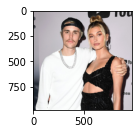

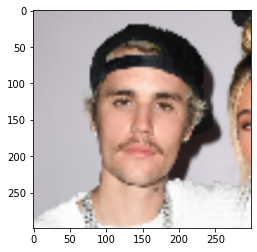

This is Justin-Bieber


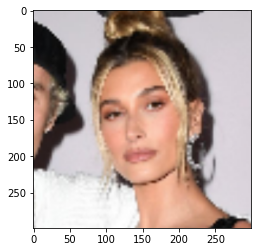

This is Other


In [ ]:
img_list = cropped_im(url, local=False)

result = predict_pics(resnet152, img_list, resnet_data['idx2class']) # change the model here

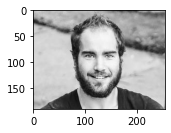

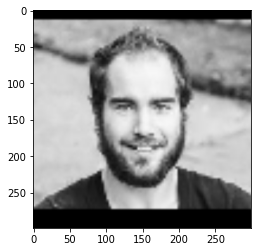

This is Other


In [ ]:
url = 'https://pi.tedcdn.com/r/pe.tedcdn.com/images/ted/90590e549b02c6c9d9492f21b549d8edff3cd374_254x191.jpg?'

img_list = cropped_im(url, local=False)

result = predict_pics(resnet152, img_list, resnet_data['idx2class']) # change the model here